In [79]:
from image_io import czi2zarr, get_mosaic_dask
import os
import numpy as np
import dask.array as da
from aicsimageio import AICSImage
import dask_image as da_image
from dask import delayed
from dask.diagnostics import ProgressBar
import zarr
from skimage.io import imshow
from matplotlib import pyplot as plt
from tifffile import imwrite



from skimage.morphology import remove_small_objects
from skimage.measure import regionprops, regionprops_table
from scipy.ndimage import distance_transform_edt
from skimage.morphology import disk
from dask_image.ndfilters import median_filter

from skimage import measure
from skimage.color import label2rgb

In [80]:

dir1 = "/vast/scratch/users/whitehead/sabrina/"
csv_file = "/vast/scratch/users/whitehead/sabrina/metLoc.csv"
raw_zarr_path = "/vast/scratch/users/whitehead/sabrina/220527_ms1070_MDA_lung1-Dual_Side_Fusion-01-Stitching-03"
c1_zarr_path = "/vast/scratch/users/whitehead/sabrina/1070_MASK_C1_threshold230"
c2_zarr_path = "/vast/scratch/users/whitehead/sabrina/1070_MASK_C2_threshold245"
c3_zarr_path = "/vast/scratch/users/whitehead/sabrina/1070_MASK_C3_threshold217"
seg_zarr_path = "/vast/scratch/users/whitehead/sabrina/seg"
vessel_zarr_path = "/vast/scratch/users/whitehead/sabrina/1070_MASK_C4_threshold140"
locThk_zarr_path = "/vast/scratch/users/whitehead/sabrina/Vessel_LocThk"

#voxel_sizes:
z_pixels, y_pixels, x_pixels =  2.8846, 1.2197, 1.2197    
x_pixels = 3 * x_pixels
y_pixels = 3 * y_pixels

In [81]:
c1_zarr = da.from_zarr(c1_zarr_path)
c2_zarr = da.from_zarr(c2_zarr_path)
c3_zarr = da.from_zarr(c3_zarr_path)
seg_zarr = da.from_zarr(seg_zarr_path)
raw_zarr = da.from_zarr(raw_zarr_path)
vessel_zarr = da.from_zarr(vessel_zarr_path)
locThk_zarr = da.from_zarr(locThk_zarr_path)

voxel_volume = x_pixels * y_pixels * z_pixels
voxel_volume

38.621946351726

In [82]:
all_mets = []
with open(csv_file, 'r') as f:
    print(f.readline())
    for l in f:
        line = str.split(l, ',')
        line = [int(l) for l in line]
        all_mets.append(line)

for l in all_mets:
    l[1] = l[1] * voxel_volume

output_dir = os.path.join(dir1, 'output_mets')

Label,Volume,Box.X.Min,Box.X.Max,Box.Y.Min,Box.Y.Max,Box.Z.Min,Box.Z.Max



In [83]:

def make_binary(im,binary_value):
    binVal = 2 ** binary_value
    x = binVal * (im / 255)
    return x

In [84]:
for met in all_mets[15006:]:
    if met[1] > 10000:

        met_num = met[0]
        met_vol = met[1]
        print("DOING MET_ID: %i" % met_num)
        print(met[1])
        # get coords:
        x1, x2, y1, y2, z1, z2 = met[2:]
        if z2 - z1 >= 3:
            print("OK")
            roi = raw_zarr[0, :, z1:z2, 3 * y1:3 * y2, 3 * x1:3 * x2]
            c1_roi = c1_zarr[z1:z2, y1:y2, x1:x2]
            c2_roi = c2_zarr[z1:z2, y1:y2, x1:x2]
            c3_roi = c3_zarr[z1:z2, y1:y2, x1:x2]
            seg_roi = seg_zarr[z1:z2, y1:y2, x1:x2] == met_num

            # mask and get lego
            c1_masked = c1_roi * seg_roi
            c2_masked = c2_roi * seg_roi
            c3_masked = c3_roi * seg_roi

            c1_bin = make_binary(c1_masked, 0)
            c2_bin = make_binary(c2_masked, 1)
            c3_bin = make_binary(c3_masked, 2)

            masked_sum = c1_bin + c2_bin + c3_bin
            z_size, y_size, x_size = masked_sum.shape

            lego = masked_sum.compute()
            asdf

DOING MET_ID: 15013
20006.168210194068
OK


NameError: name 'asdf' is not defined

In [85]:
roi.shape


(4, 20, 39, 24)

/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


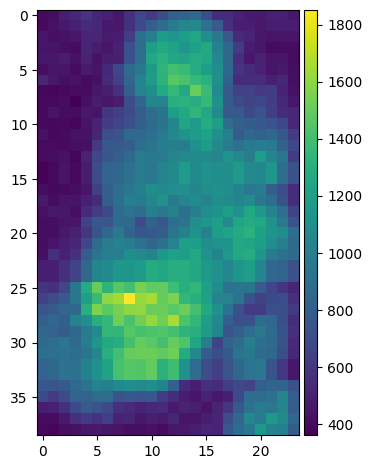

In [86]:
imshow(np.max(roi[0],axis=0))

In [87]:
w = x2 - x1
h = y2 - y1
w,h

(8, 13)

In [88]:
cx = int(x1 + w/2)
cy = int(y1 + h/2)
cx,cy

search_radius = 100






In [89]:
nearby_vessels = vessel_zarr[:,cy-search_radius:cy+search_radius,cx-search_radius:cx+search_radius]
nearby_vessels = nearby_vessels.compute()

cell_in_middle = seg_zarr[:,cy-search_radius:cy+search_radius,cx-search_radius:cx+search_radius] == met_num

#cell_in_middle = median_filter(cell_in_middle,size=4)


In [90]:
nearby_locThk = locThk_zarr[:,cy-search_radius:cy+search_radius,cx-search_radius:cx+search_radius]
nearby_locThk = nearby_locThk.compute()

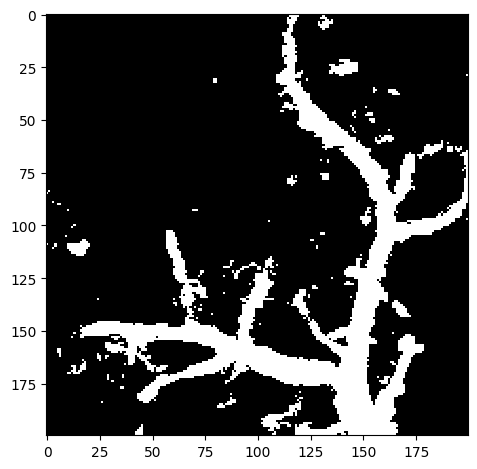

In [93]:
imshow(np.max(nearby_vessels,axis=0))

/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


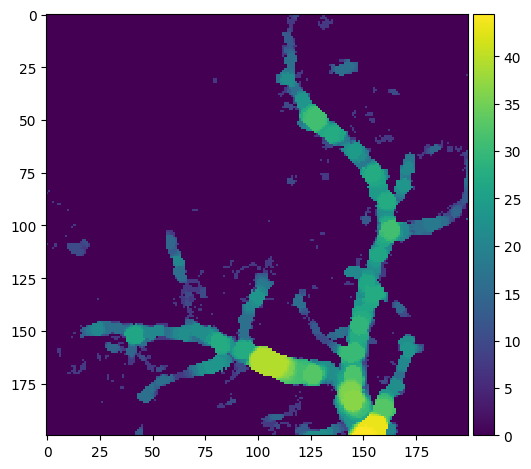

In [94]:
imshow(np.max(nearby_locThk,axis=0))

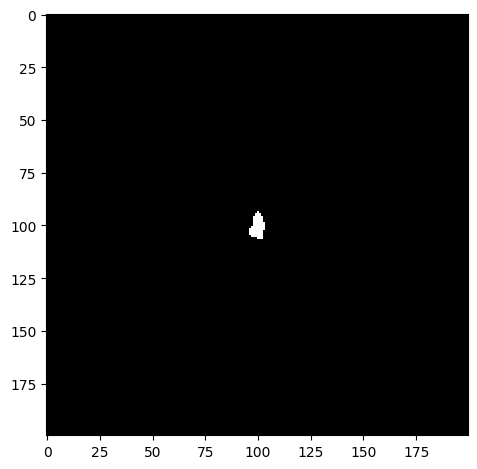

In [131]:
imshow(np.max(cell_in_middle,axis=0))

In [229]:
nearby_vessels.shape

(972, 200, 200)

In [125]:
cleaned_vessels = remove_small_objects(nearby_vessels==255,min_size=1000)
scaled_dist_transform = distance_transform_edt(1-cleaned_vessels,sampling=(z_pixels,y_pixels,x_pixels))

In [127]:
filtered_locThk = cleaned_vessels * nearby_locThk

/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


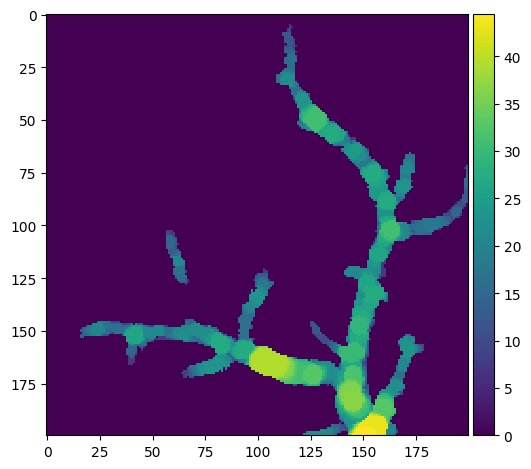

In [128]:
imshow(np.max(filtered_locThk,axis=0))

In [129]:
to_measure = cell_in_middle * scaled_dist_transform

/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)
/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Float image out of standard range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


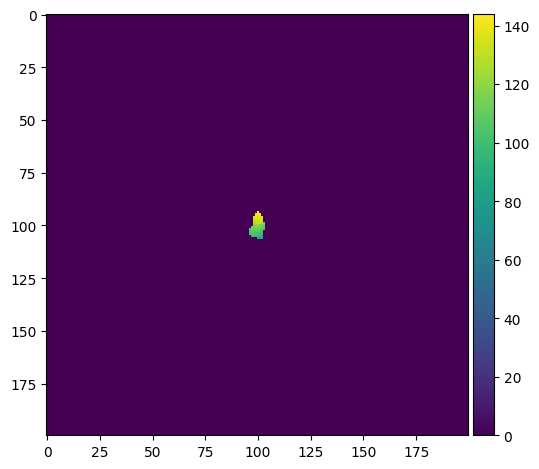

In [130]:
imshow(np.max(to_measure,axis=0))

In [132]:
lbl = measure.label(cell_in_middle)

/home/users/allstaff/whitehead/.conda/envs/bac2/lib/python3.9/site-packages/skimage/io/_plugins/matplotlib_plugin.py:150: UserWarning: Low image data range; displaying image with stretched contrast.
  lo, hi, cmap = _get_display_range(image)


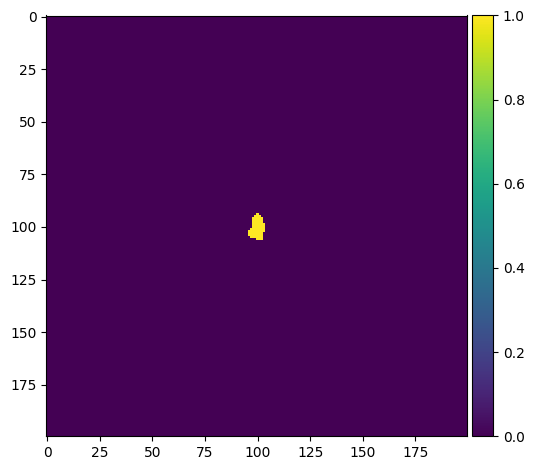

In [133]:
imshow(np.max(lbl,axis=0))

In [134]:
measurements = regionprops(lbl,intensity_image=scaled_dist_transform)

In [135]:
print(measurements[0].mean_intensity)
print(measurements[0].min_intensity)
print(measurements[0].max_intensity)

print(measurements[0].centroid)
z,y,x = measurements[0].centroid
x = int(x)
y = int(y)
z = int(z)

print(scaled_dist_transform[z,y,x])


111.72349346569854
88.26182653344536
144.10789247997488
(87.74710424710425, 100.38030888030887, 99.82625482625483)
113.9239467285522


In [159]:
dist_from_cell = distance_transform_edt(1-cell_in_middle,sampling=(z_pixels,y_pixels,x_pixels))
nearest_to_measure = ( dist_from_cell<measurements[0].mean_intensity) * filtered_locThk

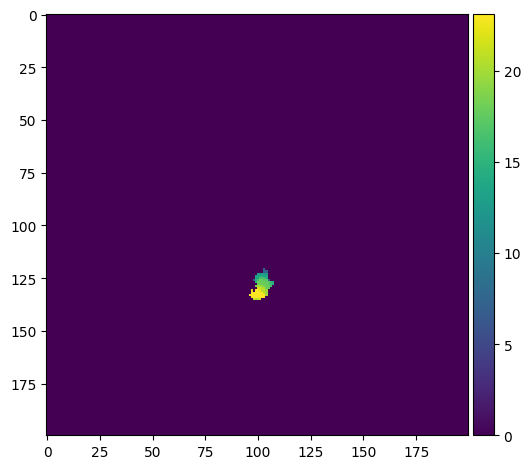

In [163]:
imshow(np.max(nearest_to_measure,axis=0))

In [164]:
loc_lbl = measure.label(nearest_to_measure>0)

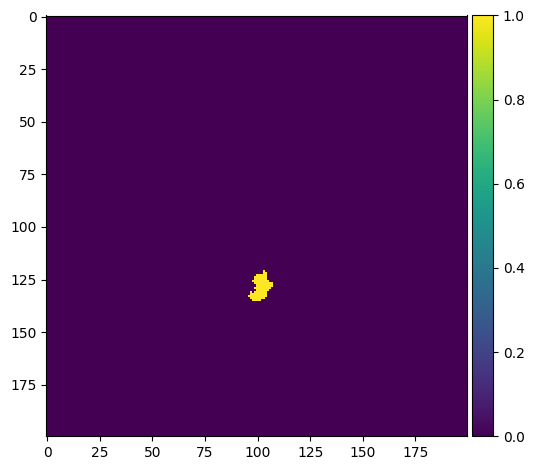

In [166]:
imshow(np.max(loc_lbl,axis=0))

In [167]:
measurements = regionprops(loc_lbl,intensity_image=filtered_locThk)

In [168]:
print(measurements[0].mean_intensity)
print(measurements[0].min_intensity)
print(measurements[0].max_intensity)

17.65135
7.31820011138916
23.142183303833008
